In [1]:
import nibabel as nib
import numpy as np
import pydicom as pydicom
import os
import sys
import shutil
import SimpleITK as sitk
from glob import glob
import time

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
mypath = "/data/Datasets/stroke/clinical_validation"
mypath_output = "dicom2"
mylist = os.listdir(mypath)
mylist.sort()

In [3]:
def writeSlices(series_tag_values, new_img, i, out_dir, ns):
    #print("GG", i)
    #print("GG", ns)
    image_slice = new_img[:,:,ns-i]
    writer = sitk.ImageFileWriter()
    writer.KeepOriginalImageUIDOn()

    # Tags shared by the series.
    list(map(lambda tag_value: image_slice.SetMetaData(tag_value[0], tag_value[1]), series_tag_values))

    # Slice specific tags.
    image_slice.SetMetaData("0008|0012", time.strftime("%Y%m%d")) # Instance Creation Date
    image_slice.SetMetaData("0008|0013", time.strftime("%H%M%S")) # Instance Creation Time

    # Setting the type to CT preserves the slice location.
    image_slice.SetMetaData("0008|0060", "CT")  # set the type to CT so the thickness is carried over

    # (0020, 0032) image position patient determines the 3D spacing between slices.
    image_slice.SetMetaData("0020|0032", '\\'.join(map(str,new_img.TransformIndexToPhysicalPoint((0,0,i))))) # Image Position (Patient)
    image_slice.SetMetaData("0020,0013", str(i)) # Instance Number

    # Write to the output directory and add the extension dcm, to force writing in DICOM format.
    #writer.SetFileName(os.path.join(out_dir,'slice' + str(i).zfill(4) + '.dcm'))
    writer.SetFileName(os.path.join(out_dir, "I"+str(i+1).zfill(5)+".dcm"))
    writer.Execute(image_slice)


def nifti2dicom_1file(in_dir, out_dir):
    """
    This function is to convert only one nifti file into dicom series

    `nifti_dir`: the path to the one nifti file
    `out_dir`: the path to output
    """

    os.makedirs(out_dir, exist_ok=True)

    new_img = sitk.ReadImage(in_dir)
    modification_time = time.strftime("%H%M%S")
    modification_date = time.strftime("%Y%m%d")

    direction = new_img.GetDirection()
    series_tag_values = [("0008|0031",modification_time), # Series Time
                    ("0008|0021",modification_date), # Series Date
                    ("0008|0008","DERIVED\\SECONDARY"), # Image Type
                    ("0020|000e", "1.2.826.0.1.3680043.2.1125."+modification_date+".1"+modification_time), # Series Instance UID
                    ("0020|0037", '\\'.join(map(str, (direction[0], direction[3], direction[6],# Image Orientation (Patient)
                                                        direction[1],direction[4],direction[7])))),
                    ("0008|103e", "Created-Pycad")] # Series Description

    # Write slices to output directory
    #print("GG", new_img.GetDepth())
    ns = new_img.GetDepth()-1
    list(map(lambda i: writeSlices(series_tag_values, new_img, i, out_dir, ns), range(new_img.GetDepth())))

In [4]:
def nifti2dicom(in_dir, out_dir):
    nifti_file = nib.load(in_dir).get_fdata()
    nifti_file = np.rot90(nifti_file, axes=(0,1))
    
    os.makedirs(out_dir, exist_ok=True)
    if nifti_file.ndim > 3:
        nifti_file = nifti_file[:,:,:,0,0]

    ds = pydicom.dcmread('I00001')
    print(nifti_file.shape)
    for s in range(nifti_file.shape[2]):
        ds.PixelData = nifti_file[...,s].astype('int16').tobytes()
        ds.save_as(os.path.join(out_dir, "I"+str(s+1).zfill(5)))
        #print("I"+str(s+1).zfill(5))
        #break

In [5]:
import glob

path = r'*.nii.gz'
mylist2 = glob.glob(path)
mylist2.sort()
print(mylist2)

['ACV-130.nii.gz', 'ACV-174.nii.gz', 'ACV-192.nii.gz', 'ACV-231.nii.gz', 'ACV-240.nii.gz', 'ACV-244.nii.gz', 'ACV-245.nii.gz', 'ACV-247.nii.gz', 'ACV-248.nii.gz', 'ACV-251.nii.gz', 'ACV-256.nii.gz', 'ACV-273.nii.gz', 'ACV-274.nii.gz', 'ACV-275.nii.gz', 'ACV-291.nii.gz']


In [6]:
for fn in mylist2:
    print(fn, "......")
    #os.mkdir(os.path.join(mypath,fn,mypath_output))
    #temp_list = os.listdir(os.path.join(mypath,fn))
    #temp_list.sort()
    #temp_list = next(os.walk(os.path.join(mypath,fn)))[2]
    #for myfilename in temp_list:
    plain_fn = fn.split(".nii.gz")[0]
    newfn = plain_fn+"_ADC"
    newfn_mask = plain_fn+"_mask"
    myfilename = plain_fn+"_mask.nii"
    print(newfn)
    
    
    nifti2dicom_1file(os.path.join(mypath,plain_fn,myfilename), os.path.join(mypath,plain_fn,mypath_output,newfn_mask))
    
    #break
    #print(myfilename)
    #if "mask" in myfilename:
    #    #mymask = True
    #    nifti2dicom_1file(os.path.join(mypath,fn,myfilename), os.path.join(mypath,fn,mypath_output,newfn))
    #else:
    #    nifti2dicom(os.path.join(fn), os.path.join(mypath,fn.split(".nii.gz")[0],mypath_output,newfn))
    nifti2dicom(os.path.join(fn), os.path.join(mypath,fn.split(".nii.gz")[0],mypath_output,newfn))
    #break       
    #os.mkdir(os.path.join(mypath,fn,mypath_output,newfn))
    #break

ACV-130.nii.gz ......
ACV-130_ADC
(256, 256, 24)
ACV-174.nii.gz ......
ACV-174_ADC
(256, 256, 24)
ACV-192.nii.gz ......
ACV-192_ADC
(256, 256, 24)
ACV-231.nii.gz ......
ACV-231_ADC
(256, 256, 26)
ACV-240.nii.gz ......
ACV-240_ADC
(256, 256, 24)
ACV-244.nii.gz ......
ACV-244_ADC
(256, 256, 26)
ACV-245.nii.gz ......
ACV-245_ADC
(256, 256, 24)
ACV-247.nii.gz ......
ACV-247_ADC
(256, 256, 25)
ACV-248.nii.gz ......
ACV-248_ADC
(256, 256, 24)
ACV-251.nii.gz ......
ACV-251_ADC
(256, 256, 24)
ACV-256.nii.gz ......
ACV-256_ADC
(256, 256, 26)
ACV-273.nii.gz ......
ACV-273_ADC
(256, 256, 26)
ACV-274.nii.gz ......
ACV-274_ADC
(256, 256, 26)
ACV-275.nii.gz ......
ACV-275_ADC
(256, 256, 26)
ACV-291.nii.gz ......
ACV-291_ADC
(256, 256, 24)


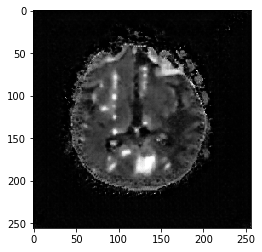

In [20]:
#ACV-130
ds = pydicom.dcmread(os.path.join(mypath,plain_fn,mypath_output,plain_fn+"_ADC","I00012"))
plt.imshow(ds.pixel_array, cmap="gray")
plt.show()

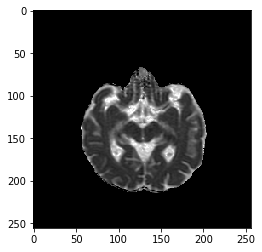

In [8]:
ds = pydicom.dcmread(os.path.join(mypath,"ACV-234","dicom","ACV-234_ADC","I00012"))
plt.imshow(ds.pixel_array, cmap="gray")
plt.show()